In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from amadeus import Client, ResponseError
from amadeus import Location

from typing import TypedDict
from typing import Annotated

import requests

from dotenv import load_dotenv 
load_dotenv()

import os

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
def get_flight_details(originLocation: str, distinationLocation: str, date: str, adults: int):
    '''This function provide the details of the flights'''

    amadeus_flight = Client()

    response = amadeus_flight.shopping.flight_offers_search.get(
        originLocationCode=originLocation,
        destinationLocationCode=distinationLocation,
        departureDate=date,
        adults=adults
    )

    return response.data[0:2]

def get_airport_code(city:str):
    '''This function provide the airport code based on given city'''

    amadues_code = Client()
    
    code_repoonse = amadues_code.reference_data.locations.get(keyword='LON', subType=Location.ANY)

    return code_repoonse


def curreny_converter(base_curreny:str, target_currency:str):
    '''this function convert curreny from EUR(base currency) to INR(target curreny)'''

    url_currency = f"https://v6.exchangerate-api.com/v6/2daabdcbf5800f70d4db2aef/pair/{base_curreny}/{target_currency}"

    currency_response = requests.get(url=url_currency)
    
    return currency_response.json()

In [4]:
llm = ChatOpenAI()

tools = [get_flight_details,get_airport_code,curreny_converter]

llm_with_tools = llm.bind_tools(tools=tools)

In [5]:
def planner_chatbot(state: State):
    return {"messages": llm_with_tools.invoke(state['messages']) }

In [6]:
graph_builder = StateGraph(State)

graph_builder.add_node('planner_chatbot',planner_chatbot)
graph_builder.add_node('tools',ToolNode(tools=tools))

graph_builder.add_edge(START,"planner_chatbot")
graph_builder.add_conditional_edges("planner_chatbot",tools_condition)
graph_builder.add_edge("tools","planner_chatbot")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

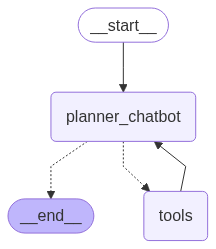

In [7]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
config = {'configurable':{'thread_id':"1"}}

In [9]:
response = graph.invoke({"messages":"I want to book flight tickets"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Sure, I can help you with that. Could you please provide me with the following details:
1. Origin Location
2. Destination Location
3. Date of Travel
4. Number of Adults traveling


In [10]:
response['messages']

[HumanMessage(content='I want to book flight tickets', additional_kwargs={}, response_metadata={}, id='bbe66160-d035-4b6e-9d4d-0a3a75e93801'),
 AIMessage(content='Sure, I can help you with that. Could you please provide me with the following details:\n1. Origin Location\n2. Destination Location\n3. Date of Travel\n4. Number of Adults traveling', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 141, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlaVtPjq5txDuNoUoMt16IrfSYiZQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3c62f1c9-9489-4dbe-a7ad-6ca5c659c8a3-0', usage_metadata={'input_tokens': 141, 'output_tokens': 42, 'total_tokens':

In [11]:
response = graph.invoke({"messages":"i want to book from delhi to mumbai for 7th July 2025"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Sure, I can help you with that. Could you please provide me with the following details:
1. Origin Location
2. Destination Location
3. Date of Travel
4. Number of Adults traveling
================================ Human Message =================================

i want to book from delhi to mumbai for 7th July 2025
================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_HtrzSeE3aEQPfaMhNNZC7GCO)
 Call ID: call_HtrzSeE3aEQPfaMhNNZC7GCO
  Args:
    city: Delhi
================================= Tool Message =================================
Name: get_airport_code

================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_Gn1RCRftwPIScPUA6HoabrCy)
 Call ID: call_Gn1RCRftwPIScPUA6Ho

In [12]:
response['messages']

[HumanMessage(content='I want to book flight tickets', additional_kwargs={}, response_metadata={}, id='bbe66160-d035-4b6e-9d4d-0a3a75e93801'),
 AIMessage(content='Sure, I can help you with that. Could you please provide me with the following details:\n1. Origin Location\n2. Destination Location\n3. Date of Travel\n4. Number of Adults traveling', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 141, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlaVtPjq5txDuNoUoMt16IrfSYiZQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3c62f1c9-9489-4dbe-a7ad-6ca5c659c8a3-0', usage_metadata={'input_tokens': 141, 'output_tokens': 42, 'total_tokens':

In [14]:
response = graph.invoke({"messages":"I want to book flight number 1"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Sure, I can help you with that. Could you please provide me with the following details:
1. Origin Location
2. Destination Location
3. Date of Travel
4. Number of Adults traveling
================================ Human Message =================================

i want to book from delhi to mumbai for 7th July 2025
================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_HtrzSeE3aEQPfaMhNNZC7GCO)
 Call ID: call_HtrzSeE3aEQPfaMhNNZC7GCO
  Args:
    city: Delhi
================================= Tool Message =================================
Name: get_airport_code

================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_Gn1RCRftwPIScPUA6HoabrCy)
 Call ID: call_Gn1RCRftwPIScPUA6Ho